In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from tqdm import tqdm
from contextlib import redirect_stdout
from io import StringIO

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score

from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


**Loading data**

Data was obtained from [here](https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset).

In [2]:
df = pd.read_csv("cardio_train.csv", delimiter=";")

Taking a peek into the data:

In [3]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [5]:
for c in df.columns:
    print(c)
    print(df[c].unique())
    print(df[c].nunique(), end="\n\n")

id
[    0     1     2 ... 99996 99998 99999]
70000

age
[18393 20228 18857 ... 14925 17727 17926]
8076

gender
[2 1]
2

height
[168 156 165 169 151 157 178 158 164 173 181 172 170 154 162 163 153 159
 166 155 160 175 171 152 187 148 179 180 188 185 167 183 174 176 161 184
 177 182  76 149 142 150 144 147 186 146 141 195 140 198 145 143 196 138
 194 190 134 136 100 120 189 137 192 122 250 191 117  70  97 119 130 110
 193  75 132  71 135  67 125 139 133  74  98 112 207  68  55  81  80  64
  91  60 109  72 197  65 128 105 108 200 104 111 113  96 131  59  66  99
  57]
109

weight
[ 62.    85.    64.    82.    56.    67.    93.    95.    71.    68.
  80.    60.    78.   112.    75.    52.    83.    69.    90.    45.
  65.    59.    66.    74.   105.    73.    55.    70.    72.    63.
  50.   107.    84.    77.    79.    76.    58.   115.    97.    53.
  57.    49.   110.    94.    92.    87.   103.    88.    99.   100.
  61.    48.    54.    51.    47.    91.   104.    81.    98.   108.
  8

The whole dataset (categorical & numerical variables) already has a fully numerical representation. For EDA the numerical values of categorical values are mapped to their meaning in text form. There is a function to map the values back to numerical values.

# 1. Data Preparation and Data Clearning

List of categorical and numerical features (target varibale excluded):

In [6]:
categorical = ["gender", "cholesterol", "gluc", "smoke", "alco", "active",]
numerical   = ["age", "height", "weight", "ap_hi", "ap_lo"]

In [7]:
df_eda = df.copy() # copying the original dataframe

Looking into the categorical values

In [8]:
def df_get_unique(df):
    # Unique values of categorical columns
    for col in df.columns:
        print(f"{col:<{20}}: ", df[col].nunique(), df[col].unique())

df_get_unique(df_eda[categorical])

gender              :  2 [2 1]
cholesterol         :  3 [1 3 2]
gluc                :  3 [1 2 3]
smoke               :  2 [0 1]
alco                :  2 [0 1]
active              :  2 [1 0]


Mapping categorical values to text for EDA:

In [9]:
gender_map = {1: "female", 2: "male"}
cholesterol_map = {1: "normal", 2: "above normal", 3: "well above normal"}
gluc_map = {1: "normal", 2: "above normal", 3: "well above normal"}
smoke_map = {0: "non-smoker", 1: "smoker"}
alco_map = {0: "non-drinker", 1: "drinker"}
active_map = {0: "in-active", 1: "active"}
# cardio_map = {0: "absent", 1: "present"}

def invert_map(mapping):
    return {v: k for k, v in mapping.items()}

def categorical_to_text(df):
    df["gender"] = df["gender"].map(gender_map)
    df["cholesterol"] = df["cholesterol"].map(cholesterol_map)
    df["gluc"] = df["gluc"].map(gluc_map)
    df["smoke"] = df["smoke"].map(smoke_map)
    df["alco"] = df["alco"].map(alco_map)
    df["active"] = df["active"].map(active_map)
    # df["cardio"] = df["cardio"].map(cardio_map)

    return df

def text_to_categorical(df):
    df["gender"] = df["gender"].map(invert_map(gender_map))
    df["cholesterol"] = df["cholesterol"].map(invert_map(cholesterol_map))
    df["gluc"] = df["gluc"].map(invert_map(gluc_map))
    df["smoke"] = df["smoke"].map(invert_map(smoke_map))
    df["alco"] = df["alco"].map(invert_map(alco_map))
    df["active"] = df["active"].map(invert_map(active_map))
    # df["cardio"] = df["cardio"].map(invert_map(cardio_map))

    return df

df_eda = categorical_to_text(df_eda)

In [10]:
df_get_unique(df_eda[categorical])

gender              :  2 ['male' 'female']
cholesterol         :  3 ['normal' 'well above normal' 'above normal']
gluc                :  3 ['normal' 'above normal' 'well above normal']
smoke               :  2 ['non-smoker' 'smoker']
alco                :  2 ['non-drinker' 'drinker']
active              :  2 ['active' 'in-active']


In [11]:
df_eda.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,male,168,62.0,110,80,normal,normal,non-smoker,non-drinker,active,0
1,1,20228,female,156,85.0,140,90,well above normal,normal,non-smoker,non-drinker,active,1
2,2,18857,female,165,64.0,130,70,well above normal,normal,non-smoker,non-drinker,in-active,1
3,3,17623,male,169,82.0,150,100,normal,normal,non-smoker,non-drinker,active,1
4,4,17474,female,156,56.0,100,60,normal,normal,non-smoker,non-drinker,in-active,0


Now that all categorical values are converted the string-processing can be done:

In [12]:
# Replacing all white-spaces in column names
df_eda.columns = df_eda.columns.str.replace(" ", "_").str.lower()

# Replacing all white-spaces in entries
for c in categorical:
    df_eda[c] = df_eda[c].str.lower().str.replace(" ", "_")

Handle missing values:

In [13]:
df_eda.isna().sum() # There are no missing values

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [14]:
df_eda.describe()

,id,age,height,weight,ap_hi,ap_lo,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,164.359229,74.205690,128.817286,96.630414,0.499700
std,28851.302323,2467.251667,8.210126,14.395757,154.011419,188.472530,0.500003
min,0.000000,10798.000000,55.000000,10.000000,-150.000000,-70.000000,0.000000
25%,25006.750000,17664.000000,159.000000,65.000000,120.000000,80.000000,0.000000
50%,50001.500000,19703.000000,165.000000,72.000000,120.000000,80.000000,0.000000
75%,74889.250000,21327.000000,170.000000,82.000000,140.000000,90.000000,1.000000
max,99999.000000,23713.000000,250.000000,200.000000,16020.000000,11000.000000,1.000000


There is still the variable `id` present that is not really informative and therefore is dropped. Additionally the age column is converted from days to years in order to be more informative for a human reader / viewer.

For readability the column names of `ap_hi` and `ap_lo` are converted to `sys` and `dia`.

There are also some very weird and implausible values in the blood pressure-values, that can be seen in the summary statics above. One example here is 

The next steps to take therefore are:
1. Removing `id`-column
2. Converting `age` to year format while retaining the original column
3. Converting the blood-pressure column-names to more adequate names
4. Handling of implausible values in the blood pressure related columns

In [17]:
# 1. Removin the id-column
if "id" in df_eda.columns:
    df_eda.drop(columns=["id"], inplace=True)
df_eda.columns

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [18]:
# 2. Converting `age` to year format while retaining the original column
df_eda["age"] = df_eda["age"].apply(lambda days: days // 365)
print(sorted(df_eda["age"].unique()))

[0]


In [19]:
# 3. Converting the blood-pressure column-names to more adequate names
df_eda.rename(columns={"ap_hi": "sys", "ap_lo": "dia"}, inplace=True)
df_eda.columns

Index(['age', 'gender', 'height', 'weight', 'sys', 'dia', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [20]:
# 4. Handling of implausible values in the blood pressure related columns

# Transform negative blood-pressure values (impossible) to positive
df_eda["sys"] = df_eda["sys"].abs()
df_eda["dia"] = df_eda["dia"].abs()
df_eda.describe() 


,age,height,weight,sys,dia,cardio
count,70000.0,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,0.0,164.359229,74.205690,128.841429,96.632414,0.499700
std,0.0,8.210126,14.395757,153.991223,188.471505,0.500003
min,0.0,55.000000,10.000000,1.000000,0.000000,0.000000
25%,0.0,159.000000,65.000000,120.000000,80.000000,0.000000
50%,0.0,165.000000,72.000000,120.000000,80.000000,0.000000
75%,0.0,170.000000,82.000000,140.000000,90.000000,1.000000
max,0.0,250.000000,200.000000,16020.000000,11000.000000,1.000000


Using Interquartile Range to filter out outliers:

- `height`, `weight`, `sys`, `dia` have totally implausible min- and max-values

In [21]:
# For more information see: 
# https://en.wikipedia.org/wiki/Interquartile_range#Outliers
# 

def remove_outliers(df, col):
    # Compute the IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Defining lower and upper bound
    lb = Q1 - 1.5 * IQR
    ub = Q3 + 1.5 * IQR

    # the filtered data without outliers
    df_out = df[(df[col] >= lb) & (df[col] <= ub)]
    return df_out

In [22]:
for c in ["height", "weight", "sys", "dia"]:
    df_eda = remove_outliers(df_eda, c)
df_eda.describe()

,age,height,weight,sys,dia,cardio
count,62512.0,62512.000000,62512.000000,62512.000000,62512.000000,62512.000000
mean,0.0,164.405922,73.180004,126.419232,81.698554,0.493873
std,0.0,7.531148,12.272462,14.290349,7.673303,0.499966
min,0.0,143.000000,40.000000,90.000000,65.000000,0.000000
25%,0.0,159.000000,65.000000,120.000000,80.000000,0.000000
50%,0.0,165.000000,72.000000,120.000000,80.000000,0.000000
75%,0.0,170.000000,81.000000,140.000000,90.000000,1.000000
max,0.0,186.000000,107.000000,170.000000,105.000000,1.000000


This seams like a much more plausible variable range.

The data is now "clean" enough for EDA and further processing.

# 2. EDA

How is the distribution of positive and negative class? For this we have to look at the target value `cardio`:

cardio
0    0.51
1    0.49
Name: proportion, dtype: float64


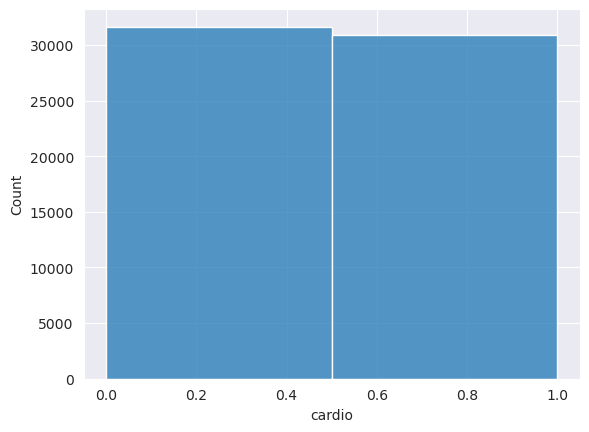

In [23]:
print(df_eda["cardio"].value_counts(normalize=True).round(2))
sns.histplot(df_eda["cardio"], bins=2) # a very good balance
plt.show()

**Insight**: A pretty good class-balance that (probably) does not require any post-processing like [SMOTE](https://arxiv.org/abs/1106.1813).

In [22]:
# global cardio_rate
global_cardio_rate = df_eda["cardio"].mean()
print("Global cardio rate:", global_cardio_rate.round(2))

Global cardio rate: 0.49


In [23]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62512 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          62512 non-null  int64  
 1   gender       62512 non-null  object 
 2   height       62512 non-null  int64  
 3   weight       62512 non-null  float64
 4   sys          62512 non-null  int64  
 5   dia          62512 non-null  int64  
 6   cholesterol  62512 non-null  object 
 7   gluc         62512 non-null  object 
 8   smoke        62512 non-null  object 
 9   alco         62512 non-null  object 
 10  active       62512 non-null  object 
 11  cardio       62512 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 6.2+ MB


**Lets have a look at all the other relevant variables:**

In [24]:
numerical = ["age", "height", "weight", "sys", "dia"]
categorical = ["gender", "cholesterol", "gluc", "smoke", "alco", "active"]

**Computing the feature importance for categorical features (Mutual Information)**

In [25]:
def mutual_info_cardio_score(series):
    return mutual_info_score(series, df_eda["cardio"])

cholesterol    0.024624
gluc           0.003834
active         0.000711
smoke          0.000246
alco           0.000076
gender         0.000011
dtype: float64

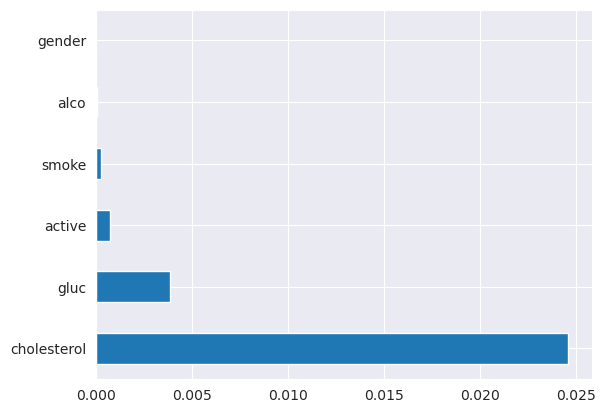

In [26]:
mi = df_eda[categorical].apply(mutual_info_cardio_score)
mi_sorted = mi.sort_values(ascending=False)
mi_sorted.plot(kind='barh')
mi_sorted

The most informative categorical featue is `cholesterol` with a large margin.

**Computing the feature importance for numerical features (Correlation)**

In [27]:
numerical

['age', 'height', 'weight', 'sys', 'dia']

sys       0.432281
dia       0.336326
age       0.236375
weight    0.161711
height   -0.027544
dtype: float64

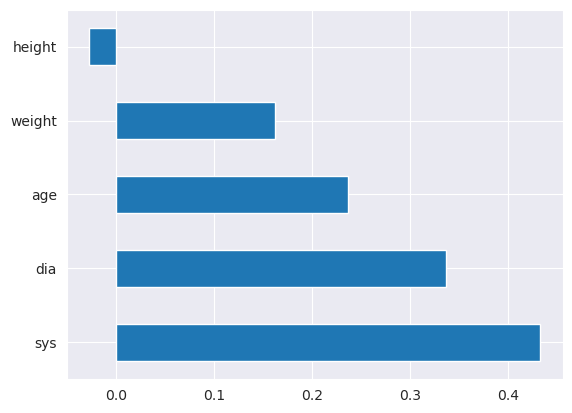

In [28]:
corr = df_eda[numerical].corrwith(df_eda["cardio"]).sort_values(ascending=False)
corr.plot(kind='barh')
corr

The biggest correlation with cardiovascular diseases are the both blood pressure values `sys` and `dia`.

**Transforming data to be used in training**

In [29]:
rs = 1  # random state

In [194]:
df_full_train, df_test = train_test_split(df_eda, test_size=0.2, random_state=rs)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=rs)

print(f"train: {len(df_train)} | {len(df_train) / len(df_eda)*100:.0f}%")
print(f"val: {len(df_val)} | {len(df_val) / len(df_eda)*100:.0f}%")
print(f"test: {len(df_test)} | {len(df_test) / len(df_eda)*100:.0f}%")

train: 37506 | 60%
val: 12503 | 20%
test: 12503 | 20%


In [31]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [32]:
# obtaining the target-values that are used for the machine learning model. default -> 1, ok -> 0 
y_train = df_train["cardio"]
y_val = df_val["cardio"]
y_test = df_test["cardio"]

In [33]:
# removing the target-values from the data
if "cardio" in df_train.columns:
    df_train.drop(["cardio"], axis=1, inplace=True)
if "cardio" in df_val.columns:
    df_val.drop(["cardio"], axis=1, inplace=True)
if "cardio" in df_test.columns:
    df_test.drop(["cardio"], axis=1, inplace=True)

In [34]:
dv = DictVectorizer(sparse=False)

train_dicts = df_train.to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val.to_dict(orient="records")
X_val = dv.transform(val_dicts)

test_dicts = df_test.to_dict(orient="records")
X_test = dv.transform(test_dicts)

print(dv.get_feature_names_out())

['active=active' 'active=in-active' 'age' 'alco=drinker'
 'alco=non-drinker' 'cholesterol=above_normal' 'cholesterol=normal'
 'cholesterol=well_above_normal' 'dia' 'gender=female' 'gender=male'
 'gluc=above_normal' 'gluc=normal' 'gluc=well_above_normal' 'height'
 'smoke=non-smoker' 'smoke=smoker' 'sys' 'weight']


# 3. Model Training

Train and tune the following models:
- Logistic Regression
- RandomForestClassifier
- XGBoost for classification

### Logistic Regression

- Trying out different `C`-values for regularization

In [182]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient="records")
    dv = DictVectorizer(sparse=False)

    X_train = dv.fit_transform(dicts)
    model = LogisticRegression(# solver='liblinear', 
                               C=C, 
                               max_iter=1_000,
                               n_jobs=-1, 
                               random_state=rs)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient="records")
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [183]:
# Choosing a small number of folds since the dataset is big
K = 2

for C in [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0]:

    scores = []

    kfold = KFold(n_splits=K, shuffle=True, random_state=rs)


    for train_idx, val_idx in kfold.split(df_full_train):
        df_train_k = df_full_train.iloc[train_idx]
        df_val_k = df_full_train.iloc[val_idx]

        y_train_k = df_train_k["cardio"].values
        y_val_k = df_val_k["cardio"].values

        dv, model = train(df_train_k, y_train_k, C)

        y_pred_k = predict(df_val_k, dv, model)

        auc = roc_auc_score(y_val_k, y_pred_k)
        scores.append(auc)

    print(f"C = {C:.5} | AUC: {np.mean(scores):.6f} +- {np.std(scores):.3f}")


C = 0.001 | AUC: 0.784240 +- 0.001


/home/user/miniconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C = 0.01 | AUC: 0.787172 +- 0.001


/home/user/miniconda3/envs/ml-zoomcamp/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C = 0.1 | AUC: 0.787046 +- 0.001
C = 0.5 | AUC: 0.787496 +- 0.001
C = 1.0 | AUC: 0.787582 +- 0.001
C = 5.0 | AUC: 0.787595 +- 0.001
C = 10.0 | AUC: 0.787599 +- 0.001


In [184]:
dv, model = train(df_full_train, df_full_train["cardio"].values, C=10.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
print(f"AUC(full): {auc:.6f}") 

AUC(full): 0.786906


The regularization term of `C=10` has yielded the highest validation-auc

### RandomForestClassifier

- Fine-tuning of:
    - `n_estimators`
    - `max_depth`
    - `min_samples_leaf`

Finding an adequate parameter for `n_estimators`:

In [38]:
scores = []
rs = 1

estimator_range = list(range(10, 201, 10))

for n in tqdm(estimator_range, total=len(estimator_range)):
    rf = RandomForestClassifier(n_estimators=n,
                                random_state=rs,
                                n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append((n, auc))

df_scores = pd.DataFrame(scores, columns=["n_estimators", "auc"])
top_scores = df_scores.sort_values(by="auc", ascending=False).head()
top_scores

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:52<00:00,  2.63s/it]


,n_estimators,auc
18,190,0.761424
19,200,0.761385
17,180,0.761274
14,150,0.761164
16,170,0.761143


In [39]:
best_n = list(top_scores["n_estimators"])[0]
best_n

190

Finding out the best parameters for `n_estimators` and `max_depth` in conjunction:

In [40]:
scores = []
rs = 1

for d in [5, 10, 15]:
    print("d = ", d)
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=rs,
                                    n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((d, n, auc))

d =  5


d =  10
d =  15


In [41]:
columns = ["max_depth", "n_estimators", "auc"]
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,max_depth,n_estimators,auc
0,5,10,0.787567
1,5,20,0.789881
2,5,30,0.790034
3,5,40,0.790425
4,5,50,0.790454


In [42]:
top_scores = df_scores.sort_values(by="auc", ascending=False).head()
top_scores

,max_depth,n_estimators,auc
38,10,190,0.799132
37,10,180,0.799087
39,10,200,0.799071
36,10,170,0.798977
35,10,160,0.798967


In [43]:
max_depth = list(top_scores["max_depth"])[0]
max_depth

10

Tuning the `min_samples_leaf`-parameter with fixed `max_depth=10`:

In [44]:
scores = []
rs = 1

for s in [1, 3, 5, 10, 50]:
    print("min_samples_leaf = ", s)
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=rs,
                                    n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((s, n, auc))

min_samples_leaf =  1


min_samples_leaf =  3
min_samples_leaf =  5
min_samples_leaf =  10
min_samples_leaf =  50


In [45]:
columns = ["min_samples_leaf", "n_estimators", "auc"]
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,min_samples_leaf,n_estimators,auc
0,1,10,0.791779
1,1,20,0.795546
2,1,30,0.796882
3,1,40,0.797858
4,1,50,0.798213


In [46]:
top_scores = df_scores.sort_values(by="auc", ascending=False).head()
top_scores

,min_samples_leaf,n_estimators,auc
24,3,50,0.799814
23,3,40,0.799756
22,3,30,0.799698
25,3,60,0.799630
38,3,190,0.799535


In [47]:
min_samples_leaf = list(top_scores["min_samples_leaf"])[0]
min_samples_leaf

3

Hyper-Parameters after tuning:

In [48]:
print("n_estimators = ", best_n)
print("max_depth = ", max_depth)
print("min_samples_leaf = ", min_samples_leaf)
print("random_state = ", rs)

n_estimators =  190
max_depth =  10
min_samples_leaf =  3
random_state =  1


The final `RandomForestClassifier` model:

In [49]:
rf = RandomForestClassifier(n_estimators=n,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=rs)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print(f"AUC = {auc:.4f}")

AUC = 0.7995


### XGBoost for classification

In [50]:
import xgboost as xgb

In [51]:
# XGBoost preprocessing

# DMatrix: data-structure optimized to be used in xgboost-models
features = dv.get_feature_names_out().tolist()

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

Tuning the following parameters (in this order):
1. **`eta`**: learning rate
2. **`max_depth`**: `max_depth` in Random Forests
3. **`min_child_weight`**: `min_samples_leaf` in Random Forests

In [107]:
watchlist = [(dtrain, "train"), (dval, "val")]

In [108]:
def parse_xgb_output(output):
    results = []
    
    for line in output.strip().split("\n"): # list of all lines
        it_line, train_line, val_line = line.split("\t")
        
        it = int(it_line.strip("[]"))
        train = float(train_line.split(":")[1])
        val = float(val_line.split(":")[1])
            
        results.append((it, train, val))
        
    columns = ["num_iter", "train_auc", "val_auc"]
    df_results = pd.DataFrame(results, columns=columns)
    
    return df_results

### 1. Tuning `eta`

In [109]:
def tune_eta(eta_list):
    
    scores = {}

    for eta in tqdm(eta_list, total=len(eta_list)):
        captured_output = StringIO()

        xgb_params = {
            "eta": eta,             # learning rate
            "max_depth": 6,         # controls size in `DecisionTreeClassifier`
            "min_child_weight": 1,
            
            "objective": "binary:logistic", # specification of model type
            "eval_metric": "auc",           # auc as shown metric
            
            "nthread": 8,                   # number of threads used for training
            "seed": rs,     # random seed
            "verbosity": 1, # show only warnings
        }

        with redirect_stdout(captured_output):
            model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                            verbose_eval=5,
                            evals=watchlist)
            
        output = captured_output.getvalue()

        key = f"eta={str(xgb_params['eta'])}"
        scores[key] = parse_xgb_output(output)
    return scores
        

In [110]:
eta_list = [1.0, 0.1, 0.05, 0.01]
scores = tune_eta(eta_list)

100%|██████████| 4/4 [00:29<00:00,  7.31s/it]


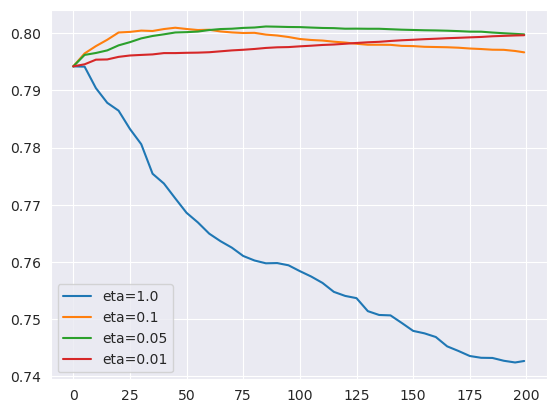

In [114]:
for eta in scores.keys():
    df_score = scores[eta]
    plt.plot(df_score["num_iter"], df_score["val_auc"], label=eta)
plt.legend()
plt.show()

In [119]:
from IPython.display import display

In [123]:
for eta in scores.keys():
    print(eta)
    df_score = scores[eta]
    display(df_score.sort_values(by="val_auc", ascending=False).head(1))

eta=1.0


,num_iter,train_auc,val_auc
0,0,0.7923,0.79418


eta=0.1


,num_iter,train_auc,val_auc
9,45,0.81226,0.80093


eta=0.05


,num_iter,train_auc,val_auc
17,85,0.81175,0.80115


eta=0.01


,num_iter,train_auc,val_auc
40,199,0.80408,0.79962


**`eta=0.05` is chosen at `num_iter=85`** since it has the highest validation auc-score in comparison to all other `eta`-scores.

### 2. Tuning `max_depth`

In [127]:
def tune_max_depth(max_depth_list, eta):
    scores = {}

    for d in tqdm(max_depth_list, total=len(max_depth_list)):
        captured_output = StringIO()

        xgb_params = {
            "eta": eta,             # learning rate
            "max_depth": d,         # controls size in `DecisionTreeClassifier`
            "min_child_weight": 1,
            
            "objective": "binary:logistic", # specification of model type
            "eval_metric": "auc",           # auc as shown metric
            
            "nthread": 8,                   # number of threads used for training
            "seed": rs,     # random seed
            "verbosity": 1, # show only warnings
        }

        with redirect_stdout(captured_output):
            model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                            verbose_eval=5,
                            evals=watchlist)
            
        output = captured_output.getvalue()

        key = f"max_depth={str(xgb_params['max_depth'])}"
        scores[key] = parse_xgb_output(output)
        
    return scores
        

In [128]:
max_depth_list = np.arange(1, 11) # [1, ..., 10]
md_scores = tune_max_depth(max_depth_list, eta=0.05)

100%|██████████| 10/10 [01:25<00:00,  8.54s/it]


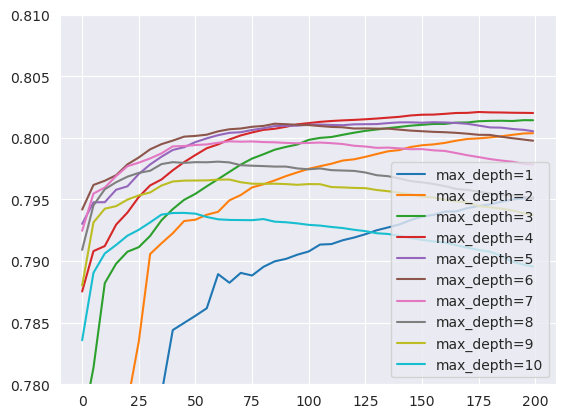

In [131]:
for max_depth, df_score in md_scores.items():
    plt.plot(df_score["num_iter"], df_score["val_auc"], label=max_depth)
plt.legend()
plt.ylim(0.78, 0.81)
plt.show()

In [130]:
for max_depth, df_score in md_scores.items():
    print(max_depth)
    display(df_score.sort_values(by="val_auc", ascending=False).head(1))

max_depth=1


,num_iter,train_auc,val_auc
40,199,0.7885,0.79515


max_depth=2


,num_iter,train_auc,val_auc
40,199,0.79478,0.80038


max_depth=3


,num_iter,train_auc,val_auc
39,195,0.79977,0.80144


max_depth=4


,num_iter,train_auc,val_auc
35,175,0.80426,0.8021


max_depth=5


,num_iter,train_auc,val_auc
31,155,0.80973,0.80127


max_depth=6


,num_iter,train_auc,val_auc
17,85,0.81175,0.80115


max_depth=7


,num_iter,train_auc,val_auc
13,65,0.81697,0.79972


max_depth=8


,num_iter,train_auc,val_auc
12,60,0.82673,0.79807


max_depth=9


,num_iter,train_auc,val_auc
13,65,0.84081,0.79662


max_depth=10


,num_iter,train_auc,val_auc
9,45,0.8484,0.79391


The parameter `max_depth=4` is chosen at 175 boosting iterations.

### 3. Tuning `min_child_weight`

In [133]:
def tune_min_child_weight(mcw_list, eta, max_depth):
    scores = {}

    for mcw in tqdm(mcw_list, total=len(mcw_list)):
        captured_output = StringIO()

        xgb_params = {
            "eta": eta,             # learning rate
            "max_depth": max_depth,         # controls size in `DecisionTreeClassifier`
            "min_child_weight": mcw,
            
            "objective": "binary:logistic", # specification of model type
            "eval_metric": "auc",           # auc as shown metric
            
            "nthread": 8,                   # number of threads used for training
            "seed": rs,     # random seed
            "verbosity": 1, # show only warnings
        }

        with redirect_stdout(captured_output):
            model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                            verbose_eval=5,
                            evals=watchlist)
            
        output = captured_output.getvalue()

        key = f"min_child_weight={str(xgb_params['min_child_weight'])}"
        scores[key] = parse_xgb_output(output)
        
    return scores
        

In [142]:
# mcw_list = [1, 10, 20, 30]
mcw_list = [1] + list(range(2, 31, 2))
mcw_scores = tune_min_child_weight(mcw_list, eta=0.05, max_depth=4)

100%|██████████| 16/16 [01:37<00:00,  6.10s/it]


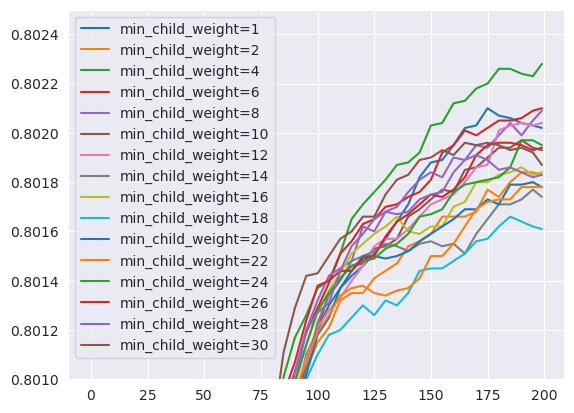

In [143]:
for min_child_weight, df_score in mcw_scores.items():
    plt.plot(df_score["num_iter"], df_score["val_auc"], label=min_child_weight)
plt.legend()
plt.ylim(0.801, 0.8025)
plt.show()

In [169]:
agg_scores = []

for min_child_weight, df_score in mcw_scores.items():
    # print(min_child_weight)
    agg_scores.append([int(min_child_weight.split("=")[-1])] + list(np.array(df_score.sort_values(by="val_auc", ascending=False).head(1))[0]))
    # display(df_score.sort_values(by="val_auc", ascending=False).head(1))

agg_scores = np.array(agg_scores)

In [172]:
columns = ["min_child_weight", "num_iter", "train_auc", "val_auc"]
df_results = pd.DataFrame(agg_scores, columns=columns)
df_results.sort_values(by="val_auc", ascending=False).head(5)

,min_child_weight,num_iter,train_auc,val_auc
2,4.0,199.0,0.80457,0.80228
0,1.0,175.0,0.80426,0.80210
3,6.0,199.0,0.80424,0.80210
4,8.0,199.0,0.80430,0.80209
6,12.0,199.0,0.80384,0.80204


The chosen value here is `min_child_weight=4`.


## Model Selection

- Choosing between `LogisticRegression`, `RandomForestClassifier` and `XGBoost` model

**`LogisticRegression`-model**

In [185]:
lr = LogisticRegression(C=10.0, max_iter=1_000, n_jobs=-1, random_state=rs)
lr.fit(X_train, y_train)

LogisticRegression(C=10.0, max_iter=1000, n_jobs=-1, random_state=1)

**`RandomForestClassifier`-model**

In [186]:
rf = RandomForestClassifier(n_estimators=190,
                            max_depth=10,
                            min_samples_leaf=3,
                            n_jobs=-1,
                            random_state=rs)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=190,
                       n_jobs=-1, random_state=1)

**`XGBoost`-model**

In [187]:
xgb_params = {
    "eta": 0.05,
    "max_depth": 4,
    "min_child_weight": 4,

    "objective": "binary:logistic",
    "eval_metric": "auc",

    "nthread": 8,
    "seed": rs,
    "verbosity": 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200)

In [188]:
# Decision Tree
y_pred = lr.predict_proba(X_val)[:, 1]
lr_auc = roc_auc_score(y_val, y_pred)

# Random Forest
y_pred = rf.predict_proba(X_val)[:, 1]
rf_auc = roc_auc_score(y_val, y_pred)

# XGBoost
y_pred = model.predict(dval)
xgb_auc = roc_auc_score(y_val, y_pred)

print(f"Decision Tree: {lr_auc:.4f}")
print(f"Random Forest: {rf_auc:.4f}")
print(f"XGBoost:       {xgb_auc:.4f}") # Winner!

Decision Tree: 0.7942
Random Forest: 0.7995
XGBoost:       0.8023


`XBoost` hast yielded the highest performance in terms of validation-auc and is chosen to be used as the final model.

### Training the final model

In [195]:
df_full_train = df_full_train.reset_index(drop=True)
y_full_train = np.array(df_full_train["cardio"])
if "cardio" in df_full_train.columns:
    del df_full_train["cardio"]

In [197]:
dicts_full_train = df_full_train.to_dict(orient="records")

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient="records")
X_test = dv.transform(dicts_test)

dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train, 
                         feature_names=dv.get_feature_names_out().tolist())
dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names_out().tolist())

In [233]:
xgb_params = {
    "eta": 0.05,
    "max_depth": 4,
    "min_child_weight": 4,

    "objective": "binary:logistic",
    "eval_metric": "auc",

    "nthread": 8,
    "seed": rs,
    "verbosity": 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200)

In [242]:
y_pred = model.predict(dtest)
final_auc = roc_auc_score(y_test, y_pred)
print(f"AUC(final) = {final_auc:.4f}")

AUC(final) = 0.7978


# Saving the final model

In [245]:
import pickle

In [246]:
output_file = f"model_xgb.bin"

In [247]:
# dv is also important for preprocessing of model-inputs
# and is saved alongside with the model
with open(output_file, 'wb') as f_out:
    pickle.dump((dv, model), f_out)